In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [54]:
batch_size = 8
num_epochs = 25
image_size = 512

In [56]:
import numpy as np
from PIL import Image # opening, manipulating, and saving many different image file formats
import matplotlib.pyplot as plt
from tqdm import tqdm #progressbar
import pandas as pd
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms #computer vision tasks
from torchvision.utils import make_grid
import torch
import torch.optim as optim # various optimization algorithms commonly used for training neural networks. It includes algorithms like SGD (Stochastic Gradient Descent), Adam, RMSprop, etc
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [57]:
text_data = pd.read_csv("/kaggle/input/flickr30k/captions.txt", sep=",")
text_data["number_of_words"] = text_data["comment"].apply(lambda text: len(text.split()))
text_data


image_name  comment_number  \
0       1000092795.jpg               0   
1       1000092795.jpg               1   
2       1000092795.jpg               2   
3       1000092795.jpg               3   
4       1000092795.jpg               4   
...                ...             ...   
158910   998845445.jpg               0   
158911   998845445.jpg               1   
158912   998845445.jpg               2   
158913   998845445.jpg               3   
158914   998845445.jpg               4   

                                                  comment  number_of_words  
0       Two young guys with shaggy hair look at their ...               17  
1       Two young  White males are outside near many b...               10  
2        Two men in green shirts are standing in a yard .               11  
3            A man in a blue shirt standing in a garden .               11  
4                 Two friends enjoy time spent together .                7  
...                                                   ...              ...  
158910  A man in shorts and a Hawaiian shirt leans ove...               24  
158911  A young man hanging over the side of a boat  w...               24  
158912  A man is leaning off of the side of a blue and...               23  
158913  A man riding a small boat in a harbor  with fo...               17  
158914  A man on a moored blue and white boat with hil...               17  

[158915 rows x 4 columns]

In [58]:
image_folder = '/kaggle/input/flickr30k/flickr30k_images'
image_filenames = os.listdir(image_folder)
image_filenames = [filename for filename in image_filenames if filename.endswith(('.jpg', '.png'))]

# image_filenames = image_filenames[0:100]

train_captions = []
test_captions = []
for image_filename in tqdm(image_filenames):
    caption = text_data[text_data['image_name']==image_filename].sort_values(by="number_of_words",ascending=False).reset_index(drop=True)['comment']
    train_caption = caption[0]
    test_caption = caption[1]
    train_captions.append( train_caption )
    test_captions.append( test_caption )

100%|██████████| 31783/31783 [14:29<00:00, 36.53it/s]


In [59]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Get the number of available processors
num_processors = os.cpu_count()

# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, image_size=224):
        self.image_filenames = image_filenames
        self.captions = captions
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),  # Resize images to a consistent size
            transforms.ToTensor(),          # Convert images to tensors
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
        ])
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image = Image.open("/kaggle/input/flickr30k/flickr30k_images" + self.image_filenames[index])
        image = self.transform(image) # .permute(2,1,0)
        text = self.captions[index]
        
        return image, text

# Create an instance of the dataset
train_dataset = ImageTextDataset(image_filenames, train_captions, image_size)
test_dataset = ImageTextDataset(image_filenames, test_captions, image_size)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=True
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*16, shuffle=False ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=False


In [60]:
import os
# Get the number of available processors
num_processors = os.cpu_count()

# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, image_size=224):
        self.image_filenames = image_filenames
        self.captions = captions
        self.transform = transforms.Compose([
                                                transforms.Resize((image_size, image_size)),  # Resize images to a consistent size
                                                transforms.ToTensor(),          # Convert images to tensors
                                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
                                            ])
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image = Image.open("/kaggle/input/flickr30k/flickr30k_images/"+image_filenames[index])
        image = self.transform(image) # .permute(2,1,0)
        text = self.captions[index]
        
        return image, text

# Create an instance of the dataset
train_dataset = ImageTextDataset(image_filenames, train_captions, image_size)
test_dataset = ImageTextDataset(image_filenames, test_captions, image_size)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=True
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*16, shuffle=False ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=False

In [61]:
# Example dataset class
# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, image_size=224):
        print("Dataset initialized")
        self.image_filenames = image_filenames
        self.captions = captions
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),  # Resize images to a consistent size
            transforms.ToTensor(),          # Convert images to tensors
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
        ])
        
        # Print the constructed file paths for debugging
        self.print_file_paths()
        
    def print_file_paths(self):
        for filename in self.image_filenames:
            file_path = f"/kaggle/input/flickr30k/flickr30k_images/{filename}"
            print("Constructed File Path:", file_path)



In [33]:
print("Train DataLoader:")
for batch_idx, (images, texts) in enumerate(train_dataloader):
    if batch_idx < 2:
        print(f"Batch {batch_idx + 1}:")
        print("Image Shape:", images.shape)
        print("Texts:", texts)
    else:
        break



Train DataLoader:
Batch 1:
Image Shape: torch.Size([32, 3, 512, 512])
Texts: ('Two women stand on an overlook  looking down at a waterfall  with a forest in the background .', 'A man riding a unicycle down a set of stairs .', 'One nun being patted down by a TSA agent in front of an American flag  while a civilian looks on .', 'A man wearing a dark jacket looks into a mirror while rubbing shaving cream on his chin and cheek  as another man looks on from the background .', 'A woman and a child are sitting on a log and stone fence with a waterfall in the background .', 'A man with a beer and another man facing each other  talking .', 'Three people  two seated on a large rolled up piece of artifcial turf and a female standing talking to one of the seated men .', 'A young girl with long brown hair  wearing a white blouse  blue skirt with purple stockings and red boots  stands along a concrete barrier  filled with blue  green and pink graffiti paint  watching a group of men play soccer .', '

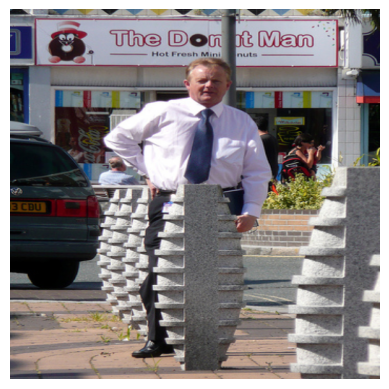

Caption: A man in a dress shirt and tie is standing in front of a sign selling donuts . 





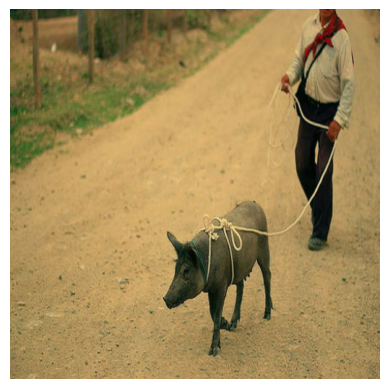

Caption: A man  wearing a red sash and white shirt  walks a pig with a long piece of rope 





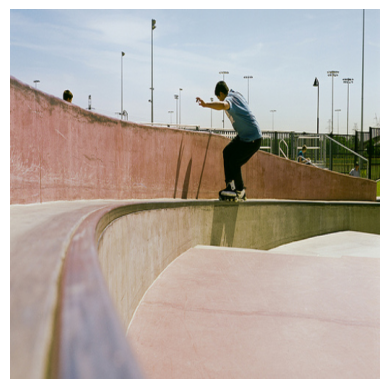

Caption: A young man in a blue shirt is grinding his skateboard at a skate park . 





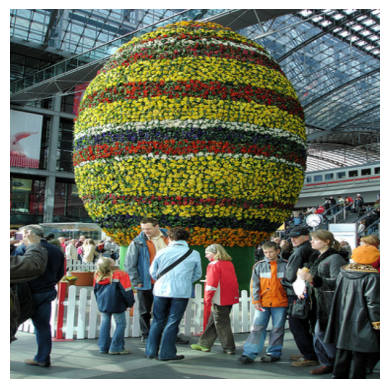

Caption: A group of people standing near a tall oval shape flower display consisting of yellow  red  white  and green flowers near a glass building . 





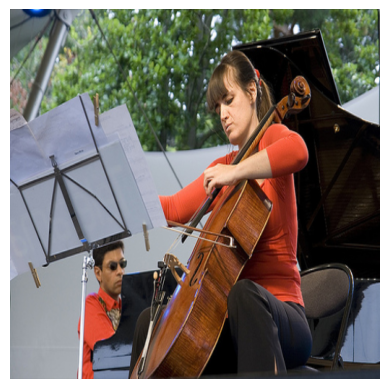

Caption: There is a woman and man wearing orange shirts  playing instruments with sheet paper in front of them . 





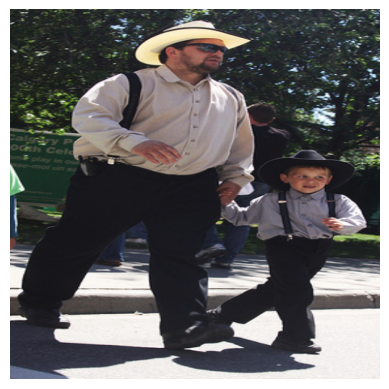

Caption: A man and a little boy in cowboy hats hold hands walking across the street . 





In [62]:
# Fetch a batch from the dataloader
batch_images, batch_texts = next(iter(train_dataloader))

for index in range(batch_images.shape[0]):
    # Fetch the image and text for the chosen index
    image_to_display = batch_images[index]
    text_to_display = batch_texts[index]

    # Convert the image tensor to a NumPy array
    image_to_display_np = image_to_display.permute(1, 2, 0).numpy()

    # Display the image using matplotlib
    plt.imshow(image_to_display_np)
    plt.axis('off')  # Turn off axis labels
    plt.show()

    # Display the corresponding text
    print("Caption:", text_to_display, "\n\n\n")
    if index>=5:
        break

In [63]:
def image_preprocessing(image_path, target_size):
    # Load the image using PIL
    img = Image.open(image_path)
    # Resize the image using PIL's resize method
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    # Convert the resized image to a NumPy array
    processed_image_array = np.array(img)
    return processed_image_array

def display_image(image_array):
    # Display the image using matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis labels
    plt.show()

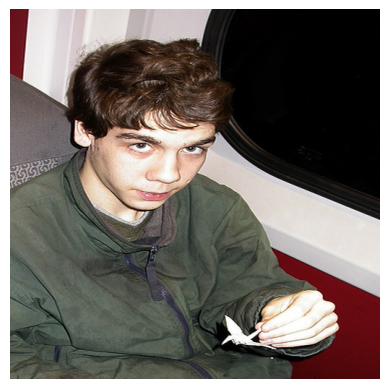

In [64]:
image = image_preprocessing("/kaggle/input/flickr30k/flickr30k_images/100759042.jpg",(image_size,image_size))
display_image(image)

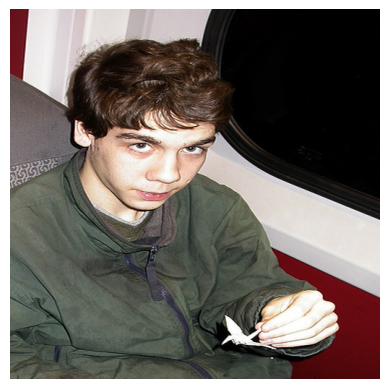

torch.Size([256, 3, 32, 32])


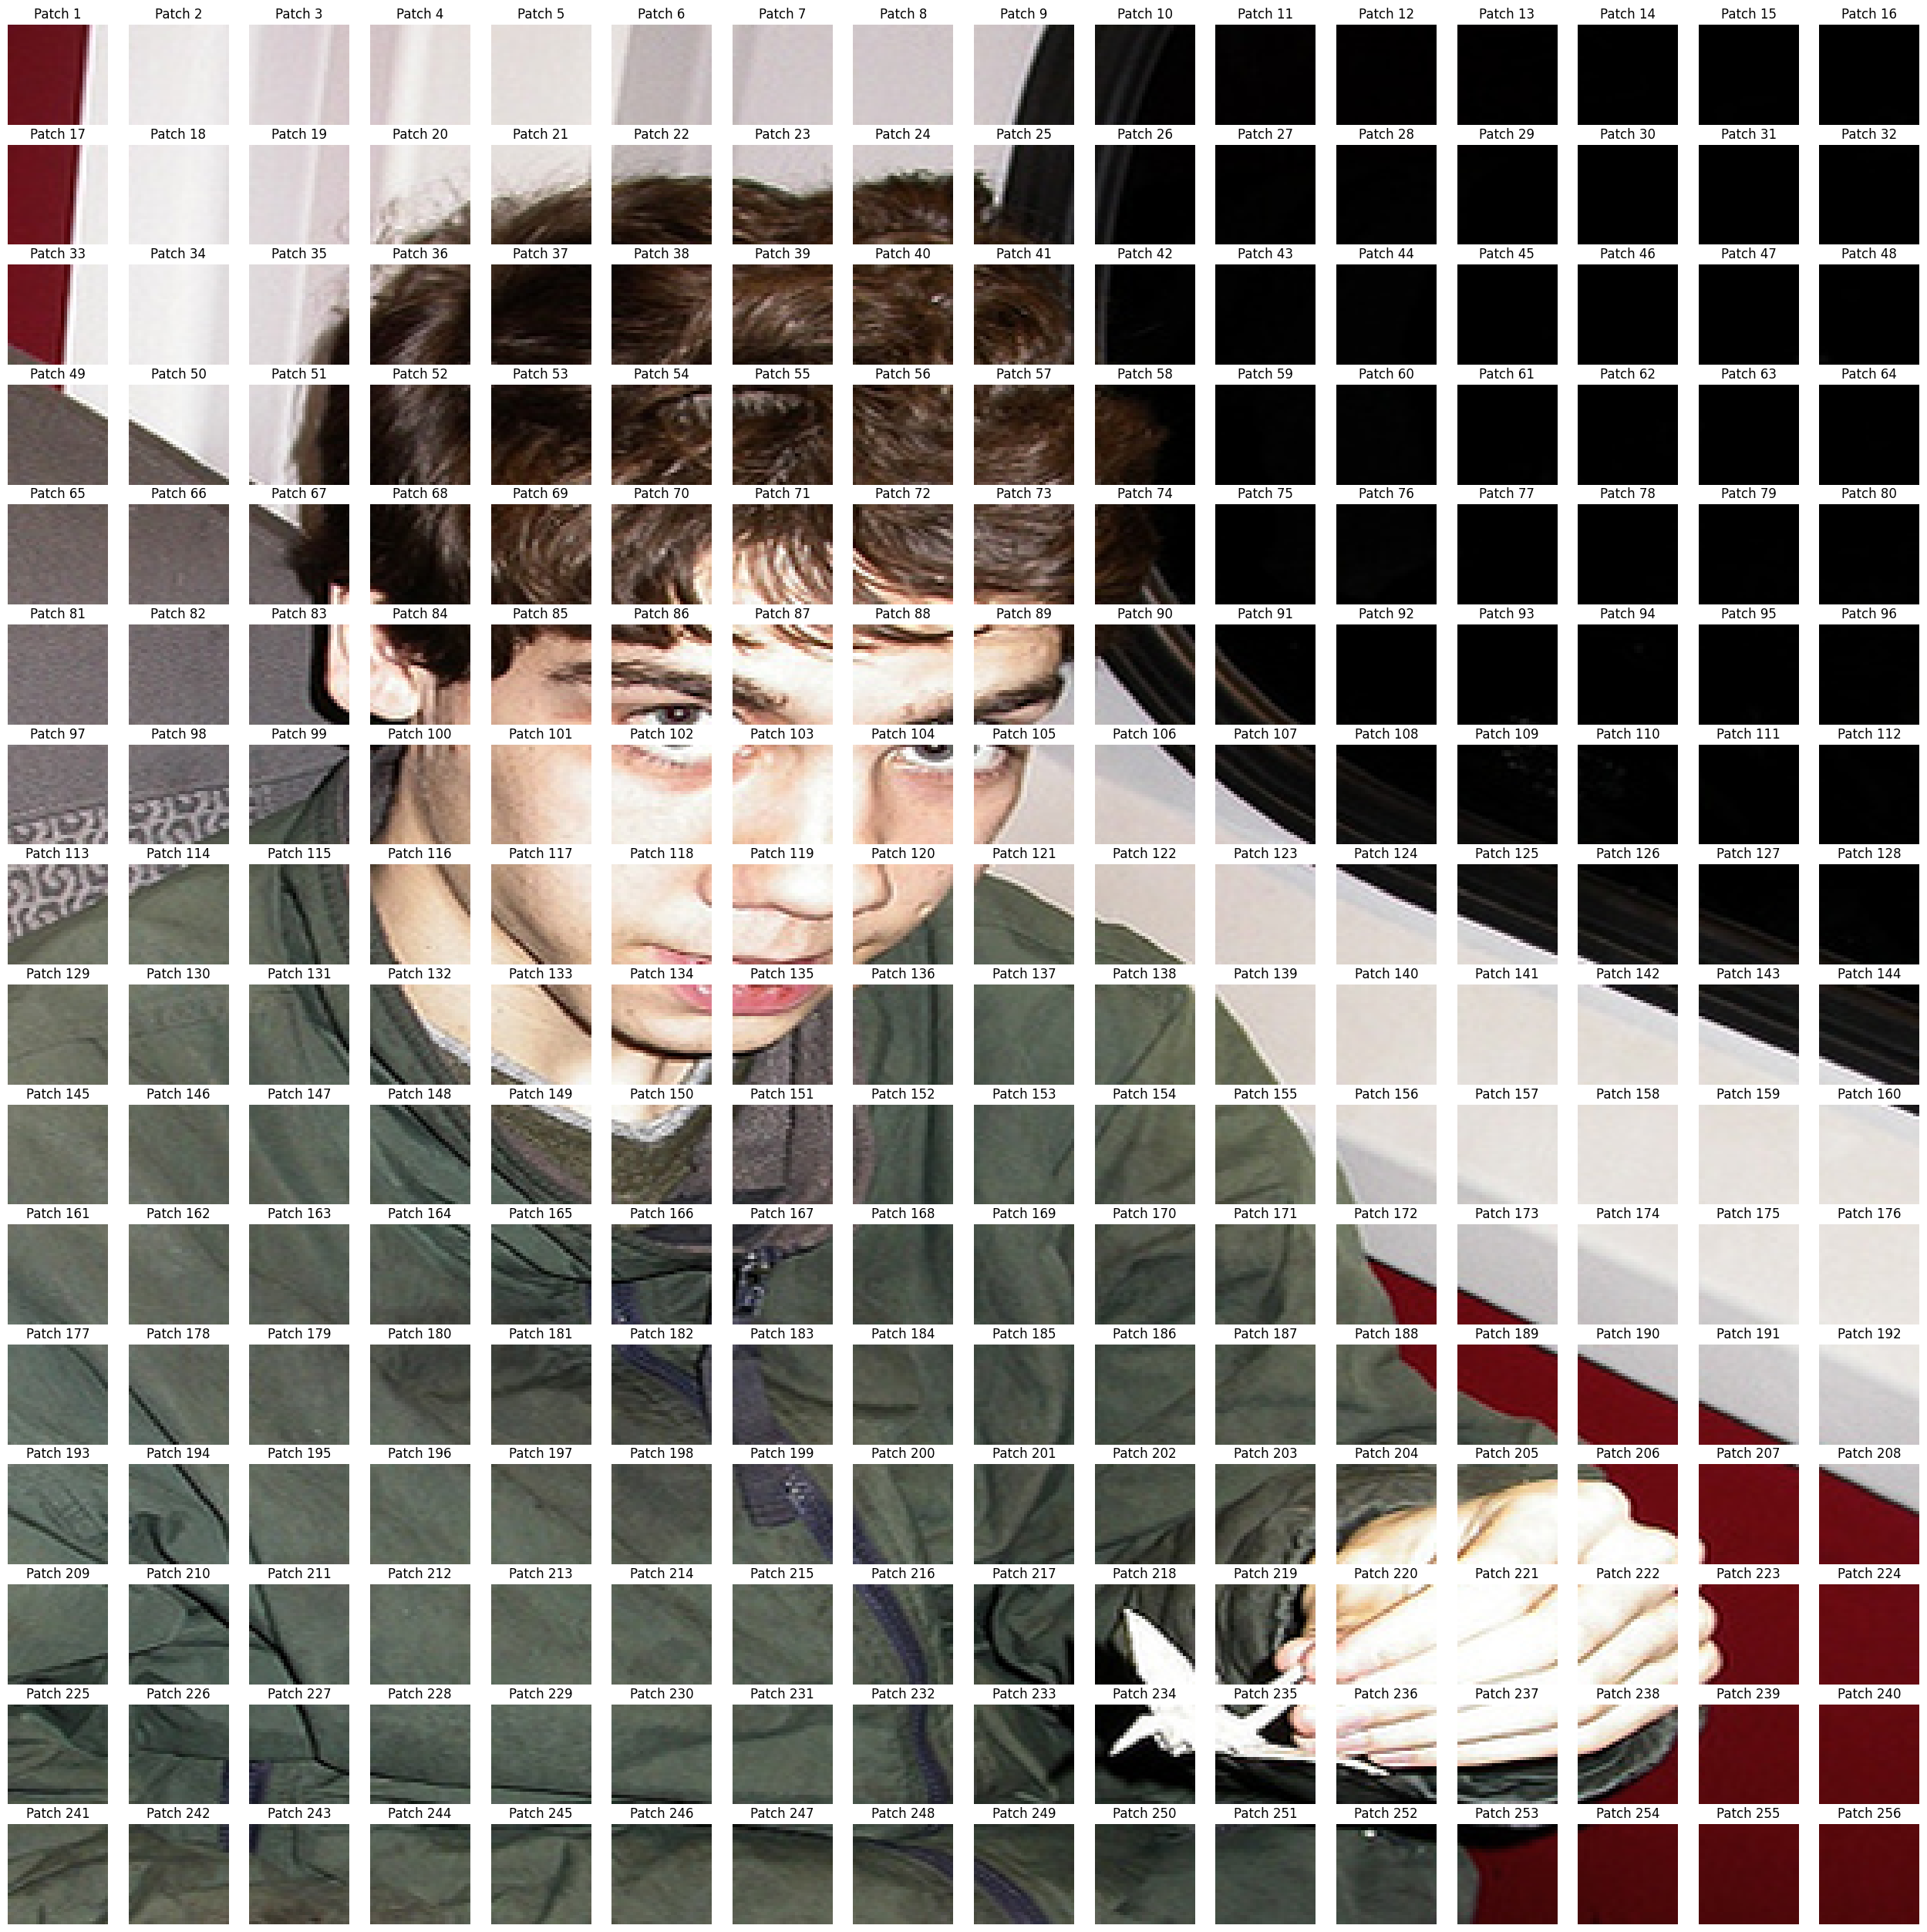

In [65]:
import torch
import matplotlib.pyplot as plt

def create_image_patches(image, patch_size):
    batch_size, channels, height, width = image.size()
    patches = []
    for h in range(0, height, patch_size):
        for w in range(0, width, patch_size):
            patch = image[:, :, h:h+patch_size, w:w+patch_size]
            patches.append(patch)
    patches = torch.cat(patches, dim=0)
    return patches

def plot_patches(patches):
    num_patches = patches.size(0)
    n = int(np.sqrt(num_patches))
    plt.figure(figsize=(2*n, 2*n))
    for i in range(num_patches):
        patch = patches[i].permute(1, 2, 0).numpy()
        plt.subplot(n, n, i + 1)
        plt.imshow(patch)
        plt.title(f"Patch {i+1}")
        plt.axis('off')
    plt.show()

# Example usage
image_size = 512
patch_size = 32

image_array = image_preprocessing("/kaggle/input/flickr30k/flickr30k_images/100759042.jpg", (image_size,image_size)) # shape: (image_size, image_size, 3)
plt.imshow(image_array)
plt.axis('off')  # Turn off axis labels
plt.show()
input_image = torch.tensor(image_array).permute(2,0,1).unsqueeze(0) # shape: (1, 3, image_size, image_size)
input_batch_image = torch.stack([input_image,input_image,input_image,input_image])
patches = create_image_patches(input_image, patch_size)
print(patches.shape)
plot_patches(patches)

In [66]:
def create_batch_patches(input_batch_image):
    batch_patches = []
    for i in range(input_batch_image.shape[0]):
        input_image = input_batch_image[i].unsqueeze(0)
        patches = create_image_patches(input_image, patch_size)
        batch_patches.append(patches)
    return torch.stack(batch_patches, dim=0)

image_array = image_preprocessing("/kaggle/input/flickr30k/flickr30k_images/100759042.jpg", (image_size,image_size)) # shape: (image_size, image_size, 3)
input_image = torch.tensor(image_array).permute(2,0,1)
input_batch_image = torch.stack([input_image,input_image,input_image,input_image])
print(input_batch_image.shape)
batch_patches = create_batch_patches(input_batch_image)
print(batch_patches.shape)

torch.Size([4, 3, 512, 512])
torch.Size([4, 256, 3, 32, 32])


In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.shape[0]

        Q = self.query(query)
        K = self.key(key)
        V = self.value(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-1, -2)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32))
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-inf"))

        attention = torch.softmax(scores, dim=-1)
        attended_values = torch.matmul(attention, V)
        attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        
        output = self.fc_out(attended_values)
        return output, attention

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, dim_feedforward, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.fc = nn.Sequential(
                                    nn.Linear(d_model, dim_feedforward),
                                    nn.ReLU(),
                                    nn.Linear(dim_feedforward, d_model),
                                )
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attended, attention = self.attention(x, x, x, mask)
        x = x + self.dropout1(self.norm1(attended))
        feedforward = self.fc(x)
        x = x + self.dropout2(self.norm2(feedforward))
        return x, attention

class VisionTransformer(nn.Module):
    def __init__(self, image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers, dropout=0.1):
        super(VisionTransformer, self).__init__()
        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        self.patch_size = patch_size
        
        self.patch_dim = 3 * patch_size ** 2
        self.patch_embeddings = nn.Linear(self.patch_dim, d_model)
        self.position_embeddings = self.generate_positional_encodings(num_patches + 1, d_model) # nn.Parameter(torch.zeros(1, num_patches + 1, d_model))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.dropout = nn.Dropout(dropout)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])

        self.fc_head = nn.Linear(d_model, image_embedding_size)
        # self.fc = nn.Linear(image_embedding_size, 10)
        
    def generate_positional_encodings(self, num_patches, d_model):
        position_encodings = torch.zeros(1, num_patches, d_model)  # Add +1 to num_patches
        position = torch.arange(0, num_patches, dtype=torch.float32).unsqueeze(1)  # Add +1 to num_patches
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * (-math.log(10000.0) / d_model))
        position_encodings[:, :, 0::2] = torch.sin(position * div_term)
        position_encodings[:, :, 1::2] = torch.cos(position * div_term)
        return position_encodings

        
    def create_image_patches(self, image):
        batch_size, channels, height, width = image.size()
        patches = []
        for h in range(0, height, self.patch_size):
            for w in range(0, width, self.patch_size):
                patch = image[:, :, h:h+self.patch_size, w:w+self.patch_size]
                patches.append(patch)
        patches = torch.cat(patches, dim=0)
        return patches
    
    def create_batch_patches(self,input_batch_image):
        batch_patches = []
        for i in range(input_batch_image.shape[0]):
            input_image = input_batch_image[i].unsqueeze(0)
            patches = self.create_image_patches(input_image)
            batch_patches.append(patches)
        return torch.stack(batch_patches, dim=0).float()
    
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.create_batch_patches(x)
        x = x.reshape(x.size(0), x.size(1), x.size(2)*x.size(3)*x.size(4))
        x = self.patch_embeddings(x)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings.to(x.device)
        for transformer in self.transformer_blocks:
            x, _ = transformer(x)

        x = x[:, 0]
        x = self.dropout(x)
        x = self.fc_head(x)
        # x = self.fc(x)
        return x

In [68]:
# Example usage
image_size = 512
patch_size = 32
d_model = 512*2
n_heads = 8
dim_feedforward = 2048
num_layers = 12
image_embedding_size=1024*4

model = VisionTransformer(image_size, patch_size, d_model, n_heads, image_embedding_size, dim_feedforward, num_layers)
model.to(device)

image_array = image_preprocessing("/kaggle/input/flickr30k/flickr30k_images/100759042.jpg", (image_size,image_size)) # shape: (image_size, image_size, 3)
input_image = torch.tensor(image_array).permute(2,0,1) # .to(device)
input_batch_image = torch.stack([input_image,input_image,input_image,input_image]).to(device)

output = model(input_batch_image)
print(output.shape)

torch.Size([4, 4096])


In [69]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel, AutoTokenizer

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name) # DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)

def generate_text_embeddings(texts):
    # Tokenize input texts
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)

    # Generate embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the embeddings from the last hidden layer
    embeddings = outputs.last_hidden_state[:, 0, :] # <---CLS # outputs.last_hidden_state.mean(dim=1)  # You can use other aggregation methods

    return embeddings

In [70]:
# List of input texts
texts = [ "yo yo CLIP Model", "DistilBERT is a great model for text embedding.", "Vision Transformers for image.", "Contrative Learning" ]

# Generate embeddings
embeddings = generate_text_embeddings(texts)
print("Shape of embeddings:", embeddings.shape)  # Should print (num_texts, embedding_size)

Shape of embeddings: torch.Size([4, 768])


In [71]:
import torch
import torch.nn as nn
dropout = 0.1
class ImageProjection(nn.Module):
    def __init__(self, image_embedding_size, shared_embedding_size):
        super(ImageProjection, self).__init__()
        self.image_projection = nn.Linear(image_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)
        
    def forward(self, image_embeddings):
        projected_embeddings = self.image_projection(image_embeddings)
        
        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)
        
        return x # projected_embeddings
class TextProjection(nn.Module):
    def __init__(self, text_embedding_size, shared_embedding_size):
        super(TextProjection, self).__init__()
        self.text_projection = nn.Linear(text_embedding_size, shared_embedding_size)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(shared_embedding_size, shared_embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(shared_embedding_size)
        
    def forward(self, text_embeddings):
        projected_embeddings = self.text_projection(text_embeddings)
        
        x = self.gelu(projected_embeddings)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected_embeddings
        x = self.layer_norm(x)
        
        return x # projected_embeddings

In [72]:
def count_trainable_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params

In [73]:
count_trainable_parameters(model)

66362880

batch_idx:  0  Image Shape:  torch.Size([8, 3, 512, 512]) Text Count:  8


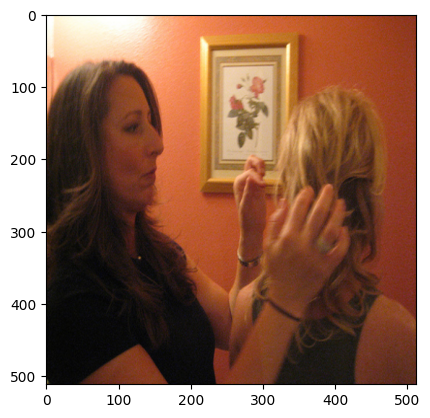

A dark-haired woman is fixing a blond woman 's hair .


In [74]:
import os

# Set the environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "true" 

# Checking Data Setup
for batch_idx, (images, texts) in enumerate(train_dataloader):
    print( "batch_idx: ", batch_idx, " Image Shape: ", images.shape, "Text Count: ", len(texts) )
    plt.imshow( torch.moveaxis( images[0], 0, 2 ).numpy() )
    plt.show()
    print(texts[0])
    break

In [76]:
dropout = 0.1

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

temperature_value = 1

def contrastive_clip_loss_function( text_projection,  image_projection, mode="eval" ):
    logits = (text_projection @ image_projection.T) / temperature_value
    if mode=="train":
        images_similarity = image_projection @ image_projection.T
        texts_similarity = text_projection @ text_projection.T
        targets = F.softmax( (images_similarity + texts_similarity) / 2 * temperature_value, dim=-1 )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()
    elif mode=="eval":
        return logits
    else:
        print("Mention mode")
        return None

In [77]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time

In [78]:
#   - - - - - - - - - - - - - - - - - -   Hyperparameters    - - - - - - - - - - - - - - - - - -
shared_embedding_size = 512  # d_e shared embedding space
learning_rate = 5e-4

#  - - - - - - - - - - - - - - - - - -   Create model components   - - - - - - - - - - - - - - - - - -
# - - - - - - - - - ResNet Model - - - - - - - - -
# Load a pre-trained ResNet model
image_embedding_size=1024*2
resnet_model = models.resnet50(pretrained=True)
# Remove the classification layer (the last fully connected layer)
resnet_model = nn.Sequential( *list(resnet_model.children())[:-1] )
resnet_model.to(device)
print(" Number of Trainable Parameters in", " ResNet50 Model :  ",   count_trainable_parameters(resnet_model))

# - - - - - - - - -  Distil BERT Model  - - - - - - - - -
max_length = 32
text_embedding_size = 768  # d_i

# Load pre-trained DistilBERT model and tokenizer
model_name = 'distilbert-base-uncased'
text_tokenizer = DistilBertTokenizer.from_pretrained(model_name) # .to(device)
text_model = DistilBertModel.from_pretrained(model_name ).to(device)
print(" Number of Trainable Parameters in", " DistilBERT model :  ",   count_trainable_parameters(text_model))

# - - - - - - - - -  Projections  - - - - - - - - -
image_projector = ImageProjection(image_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Image Projection :  ",   count_trainable_parameters(image_projector))
text_projector = TextProjection(text_embedding_size, shared_embedding_size).to(device)
print(" Number of Trainable Parameters in", " Text Projection :  ",   count_trainable_parameters(text_projector))
print("\n - - - - - - - - - - \n \n  Training......  ")

# - - - - - - - - -  Loss  - - - - - - - - -
# sym_loss_fn = SymmetricalLoss(margin=0.1).to(device)
# contrastive_loss = ContrastiveLoss(temperature=0.9)

# - - - - - - - - -  Optimizer  - - - - - - - - -
# optimizer = optim.AdamW( list(resnet_model.parameters()) + list(text_model.parameters()) + list(image_projector.parameters()) + list(text_projector.parameters()), lr=learning_rate )
params = [{"params":resnet_model.parameters(), "lr":1e-4 }, {"params":text_model.parameters(), "lr":1e-5}, 
          # {"params":image_projector.parameters(), "lr": }, {"params":text_projector.parameters(), "lr":}
          {"params": itertools.chain( image_projector.parameters(), text_projector.parameters() ), "lr":1e-3 , "weight_decay":1e-3 }
         ]
optimizer = optim.AdamW( params,  weight_decay=0. )
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( optimizer, mode="min", patience=2 , factor=0.8 )

# - - - - - - - - -  Training loop  - - - - - - - - -
for epoch in range(num_epochs):
    # Record the start time
    start_time = time.time()
    print( " - - - - - - - - - - - Epoch:", epoch+1, " - - - - - - - - - - - - "  )
    resnet_model.train()
    text_model.train()
    image_projector.train()
    text_projector.train()
    total_loss = 0.0
    
    for batch_idx, (images, texts) in enumerate(train_dataloader):
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        optimizer.zero_grad()
        
        # - - - -  Text  - - - - 
        inputs = tokenizer(texts, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state[:, 0, :] # outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - - 
        images = images.to(device)
        # images = preprocess_images(images)
        image_embeddings = resnet_model(images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # - - - -  Compute Loss  - - - -
        # loss = sym_loss_fn(image_projection, text_projection)
        # loss = contrastive_loss(image_projection, text_projection)
        loss = contrastive_clip_loss_function( text_projection,  image_projection, mode="train")
        
        # - - - -  Backpropagation  - - - -
        loss.backward()
        optimizer.step()

        # - - - - Loss print - - - -
        total_loss += loss.item()
        if batch_idx % 200 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {total_loss/((batch_idx+1)*batch_size):.4f}")
    
    
    lr_scheduler.step(total_loss)
    
    # Record the end time
    end_time = time.time()
    elapsed_time = end_time - start_time
    # - - - - Loss each epoch
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}", "  Time Taken: ", elapsed_time, " seconds" )

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 Number of Trainable Parameters in  ResNet50 Model :   23508032
 Number of Trainable Parameters in  DistilBERT model :   66362880
 Number of Trainable Parameters in  Image Projection :   1312768
 Number of Trainable Parameters in  Text Projection :   657408

 - - - - - - - - - - 
 
  Training......  
 - - - - - - - - - - - Epoch: 1  - - - - - - - - - - - - 
Epoch [1/25], Batch [0/3973], Loss: 2.2087
Epoch [1/25], Batch [200/3973], Loss: 0.7676
Epoch [1/25], Batch [400/3973], Loss: 0.5438
Epoch [1/25], Batch [600/3973], Loss: 0.4563
Epoch [1/25], Batch [800/3973], Loss: 0.4108
Epoch [1/25], Batch [1000/3973], Loss: 0.3831
Epoch [1/25], Batch [1200/3973], Loss: 0.3644
Epoch [1/25], Batch [1400/3973], Loss: 0.3508
Epoch [1/25], Batch [1600/3973], Loss: 0.3394
Epoch [1/25], Batch [1800/3973], Loss: 0.3285
Epoch [1/25], Batch [2000/3973], Loss: 0.3180
Epoch [1/25], Batch [2200/3973], Loss: 0.3073
Epoch [1/25], Batch [2400/3973], Loss: 0.2975
Epoch [1/25], Batch [2600/3973], Loss: 0.2878
Epo

In [79]:
resnet_model.eval()
image_projector.eval()

def create_image_embeddings(images):
    with torch.no_grad():
        image_embeddings = resnet_model(images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
    return image_projection

image_embeddings_list_train = []

for index in tqdm(range(len( train_dataset ))):
    images = train_dataset[index][0]
    images = images.to(device)
    image_projection = create_image_embeddings(images.unsqueeze(0))
    image_embeddings_list_train.append( image_projection[0] )
    
    
def image_retrieval_function( input_query, n , display=False): # n --> number of images
    with torch.no_grad():
        inputs = tokenizer(input_query, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
    
    similarity_scores_list = []
    for index in tqdm(range(len(image_embeddings_list_train))):
        score = torch.dot( text_projection[0], image_embeddings_list_train[index] )
        similarity_scores_list.append( score.cpu().numpy() )
    
    max_indexes = np.array(similarity_scores_list).argsort()[-n:][::-1]
    if display:
        for index in max_indexes:
            image_tensor = train_dataset[index][0]
            plt.imshow( torch.moveaxis(image_tensor, 0,2) )
            plt.show()
        return None
    else:
        return max_indexes

100%|██████████| 31783/31783 [08:56<00:00, 59.28it/s]


100%|██████████| 31783/31783 [00:01<00:00, 20979.60it/s]


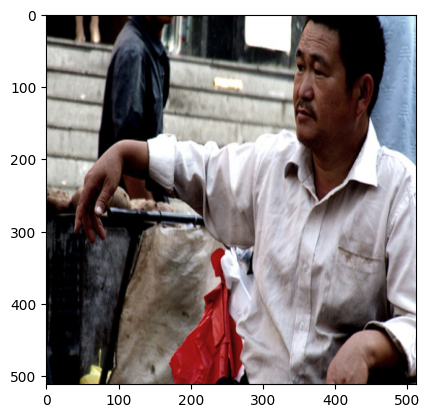

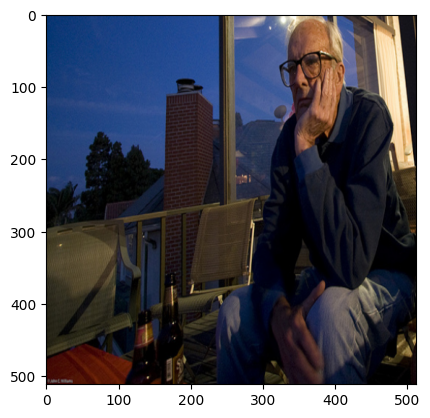

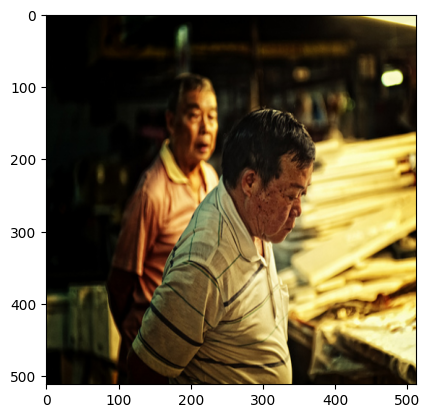

In [80]:
input_query = "man"
image_retrieval_function( input_query, n=3, display=True )

In [ ]:
input_query = "dancing girl"
image_retrieval_function( input_query, n=3, display=True )

In [ ]:
input_query = "a photo of man on road"
image_retrieval_function( input_query, n=3, display=True )

In [85]:
try:
    checkpoint = {
        #'ViT_model_dict': ViT_model.state_dict(),
        'resnet_model_dict': resnet_model.state_dict(),
        'text_model_dict': text_model.state_dict(),
        'image_projector_dict': image_projector.state_dict(),
        'text_projector_dict': text_projector.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, "/kaggle/working/ResNet-DistilBert-30k.h5")
    
except:
    print("Error in some saving")

In [89]:

# import shutil
# import os

# # Define the file path of the model
# model_file_path = '/kaggle/working/ResNet-DistilBert-30k.h5'

# # Define the destination directory where you want to save the model locally
# destination_directory = 'C:/Users/Dell/Downloads'  

# # Copy the model file to the destination directory
# shutil.copy(model_file_path, destination_directory)

# # Check if the model file has been successfully copied
# if os.path.exists(os.path.join(destination_directory, 'ResNet-DistilBert-30k.h5')):
#     print("Model file successfully copied to:", destination_directory)
# else:
#     print("Error: Failed to copy the model file.")


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Dell/Downloads'

In [ ]:
import os

# Specify the file path to delete
file_path = "/kaggle/working/ResNet-DistilBert.h5"

# Check if the file exists before attempting to delete it
if os.path.exists(file_path):
    # Delete the file
    os.remove(file_path)
    print("File has been successfully deleted.")
else:
    print("File does not exist.")


In [90]:
true_positives = 0
false_negatives = 0

with torch.no_grad():
    for batch_images, batch_captions in tqdm(test_dataloader):
        batch_size = batch_images.size(0)
        
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - - 
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - -  
        batch_images = batch_images.to(device)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot(text_projection[index_text], image_projection[index_image])
                similarity_scores_list.append(score.cpu().numpy())
            similarity_scores_list = np.array(similarity_scores_list)
        
            max_index = np.argmax(similarity_scores_list)
            if max_index == index_text:
                true_positives += 1
            else:
                false_negatives += 1

recall = true_positives / (true_positives + false_negatives)
print(f"Recall: {recall*100:.4f}")

100%|██████████| 249/249 [15:58<00:00,  3.85s/it]

Recall: 41.1069


In [91]:
accuracy_counter = 0

# ViT_model.eval()
resnet_model.eval()
text_model.eval()
image_projector.eval()
text_projector.eval()

# cosine_similarity = CosineSimilarity(temperature=temperature_value)

with torch.no_grad():
    for batch_images, batch_captions in tqdm(test_dataloader):
        batch_size = batch_images.size(0)
        
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - - 
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - -  
        batch_images = batch_images.to(device)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot( text_projection[index_text], image_projection[index_image] )
                similarity_scores_list.append( score.cpu().numpy() )
            similarity_scores_list = np.array(similarity_scores_list)
        
            max_index = np.argmax(similarity_scores_list)
            if max_index==index_text:
                accuracy_counter += 1

total_samples = len(test_dataloader.dataset)
accuracy = accuracy_counter / total_samples
print(f"Accuracy (Pencentage of Correct Matching): {accuracy*100:.4f}")

100%|██████████| 249/249 [12:56<00:00,  3.12s/it]

Accuracy (Pencentage of Correct Matching): 42.8814


In [93]:
text_data = pd.read_csv("/kaggle/input/flickr8k/captions.txt", sep="|")
text_data["number_of_words"] = text_data["caption_text"].apply(lambda text: len(text.split()))
text_data

image_name  caption_number  \
0      1000268201_693b08cb0e.jpg               0   
1      1000268201_693b08cb0e.jpg               1   
2      1000268201_693b08cb0e.jpg               2   
3      1000268201_693b08cb0e.jpg               3   
4      1000268201_693b08cb0e.jpg               4   
...                          ...             ...   
40450   997722733_0cb5439472.jpg               0   
40451   997722733_0cb5439472.jpg               1   
40452   997722733_0cb5439472.jpg               2   
40453   997722733_0cb5439472.jpg               3   
40454   997722733_0cb5439472.jpg               5   

                                            caption_text  number_of_words  
0      A child in a pink dress is climbing up a set o...               18  
1                  A girl going into a wooden building .                8  
2       A little girl climbing into a wooden playhouse .                9  
3      A little girl climbing the stairs to her playh...               10  
4      A little girl in a pink dress going into a woo...               13  
...                                                  ...              ...  
40450           A man in a pink shirt climbs a rock face               10  
40451           A man is rock climbing high in the air .               10  
40452  A person in a red shirt climbing up a rock fac...               16  
40453                    A rock climber in a red shirt .                8  
40454  A rock climber practices on a rock climbing wa...               10  

[40455 rows x 4 columns]

In [94]:
image_folder = '/kaggle/input/flickr8k/images'
image_filenames = os.listdir(image_folder)
image_filenames = [filename for filename in image_filenames if filename.endswith(('.jpg', '.png'))]

# image_filenames = image_filenames[0:100]

train_captions = []
test_captions = []
for image_filename in tqdm(image_filenames):
    caption = text_data[text_data['image_name']==image_filename].sort_values(by="number_of_words",ascending=False).reset_index(drop=True)['caption_text']
    train_caption = caption[0]
    test_caption = caption[1]
    train_captions.append( train_caption )
    test_captions.append( test_caption )

100%|██████████| 8091/8091 [01:00<00:00, 134.19it/s]


In [95]:
import os
# Get the number of available processors
num_processors = os.cpu_count()

# Example dataset class
class ImageTextDataset(Dataset):
    def __init__(self, image_filenames, captions, image_size=224):
        self.image_filenames = image_filenames
        self.captions = captions
        self.transform = transforms.Compose([
                                                transforms.Resize((image_size, image_size)),  # Resize images to a consistent size
                                                transforms.ToTensor(),          # Convert images to tensors
                                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
                                            ])
    
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, index):
        image = Image.open("/kaggle/input/flickr8k/images/"+image_filenames[index])
        image = self.transform(image) # .permute(2,1,0)
        text = self.captions[index]
        
        return image, text

# Create an instance of the dataset
train_dataset = ImageTextDataset(image_filenames, train_captions, image_size)
test_dataset = ImageTextDataset(image_filenames, test_captions, image_size)

# Create a DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=True
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*16, shuffle=False ) # , prefetch_factor=num_processors, num_workers=1, pin_memory=True, drop_last=False

In [96]:
accuracy_counter = 0

# ViT_model.eval()
resnet_model.eval()
text_model.eval()
image_projector.eval()
text_projector.eval()

# cosine_similarity = CosineSimilarity(temperature=temperature_value)

with torch.no_grad():
    for batch_images, batch_captions in tqdm(train_dataloader):
        batch_size = batch_images.size(0)
        
        # - - - - - - - - -  Forward pass  - - - - - - - - -
        # - - - -  Text  - - - - 
        inputs = tokenizer(batch_captions, return_tensors='pt', padding="max_length", max_length=max_length, truncation=True)
        inputs = inputs.to(device)
        outputs = text_model(**inputs)
        text_embeddings = outputs.last_hidden_state.mean(dim=1)
        text_projection = text_projector(text_embeddings)
        
        # - - - -  Image  - - - -  
        batch_images = batch_images.to(device)
#         image_embeddings = ViT_model(batch_images)
#         image_projection = image_projector(image_embeddings)
        image_embeddings = resnet_model(batch_images)
        image_projection = image_projector(image_embeddings[:,:,0,0])
        
        # Calculate cosine similarities
        for index_text in range(batch_size):
            similarity_scores_list = []
            for index_image in range(len(image_projection)):
                score = torch.dot( text_projection[index_text], image_projection[index_image] )
                similarity_scores_list.append( score.cpu().numpy() )
            similarity_scores_list = np.array(similarity_scores_list)
        
            max_index = np.argmax(similarity_scores_list)
            if max_index==index_text:
                accuracy_counter += 1
        
#         # Convert indices to captions for comparison
#         batch_pred_captions = [batch_captions[index] for index in batch_pred_indices]
#         batch_actual_captions = batch_captions
        
#         # Calculate accuracy
#         for pred_caption, actual_caption in zip(batch_pred_captions, batch_actual_captions):
#             if pred_caption == actual_caption:
#                 accuracy_counter += 1

total_samples = len(train_dataloader.dataset)
accuracy = accuracy_counter / total_samples
print(f"Accuracy (Pencentage of Correct Matching): {accuracy*100:.4f}")

100%|██████████| 208/208 [03:58<00:00,  1.14s/it]

Accuracy (Pencentage of Correct Matching): 41.3917


In [97]:
resnet_model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [98]:
text_model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li